# Hanami data in Japan


imports

In [755]:
from geopy.geocoders import Nominatim
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### df = pd.read_csv("sakura_first_bloom_dates

### Before cleaning the data, let's add a few things. I want to know the location (lat and long) of each of these sites. let's use nominatim for that


In [144]:
geolocator = Nominatim(user_agent="japan_sites_geocoder")

city_name = "Wakkanai"

location = geolocator.geocode(city_name)

print("lat:", location.latitude, "long:", location.longitude)

latitudes = []
longitudes = []
for site in df["Site Name"]:
    location = geolocator.geocode(site, timeout=10000)
    if location:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
        print(f"{site}: {location.latitude}, {location.longitude}")
    else:
        latitudes.append("X")
        longitudes.append("X")

lat: 45.4158108 long: 141.6730309
Wakkanai: 45.4158108, 141.6730309
Rumoi: -4.7250782, 131.7316608
Asahikawa: 43.7627501, 142.3579263
Abashiri: 44.0206027, 144.2732035
Sapporo: 43.061936, 141.3542924
Iwamizawa: 43.1960638, 141.7753595
Obihiro: 42.923809, 143.1966324
Kushiro: 42.9906837, 144.3820381
Nemuro: 43.3301518, 145.5833876
Muroran: 42.3152461, 140.9740731
Urakawa: 42.1684998, 142.7680974
Esashi: 41.8690714, 140.1272235
Hakodate: 41.768793, 140.729008
Kutchan: 42.901741, 140.7590818
Monbetsu: 44.3565151, 143.3545224
Hiroo: 42.285532, 143.3116162
Shinjo: 38.7648577, 140.3021449
Aomori: 40.886943, 140.590121
Hachinohe: 40.5122388, 141.4882959
Akita: 39.6898802, 140.342608
Morioka: 39.7021331, 141.1545397
Miyako: 39.6395835, 141.9461177
Sakata: 38.9147229, 139.8364101
Yamagata: 38.4746705, 140.083237
Sendai: 38.2677554, 140.8691498
Fukushima: 37.760777, 140.4745807
Shirakawa: 37.1263397, 140.2107192
Onahama: 36.9383759, 140.8977807
Wajima: 37.3905644, 136.8994281
Aikawa: 35.532347, 

In [146]:
df.info()
df.insert(2, "lat", latitudes)
df.insert(3, "long", longitudes)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Site Name                  102 non-null    object
 1   Currently Being Observed   102 non-null    bool  
 2   1953                       79 non-null     object
 3   1954                       81 non-null     object
 4   1955                       82 non-null     object
 5   1956                       84 non-null     object
 6   1957                       83 non-null     object
 7   1958                       83 non-null     object
 8   1959                       86 non-null     object
 9   1960                       85 non-null     object
 10  1961                       86 non-null     object
 11  1962                       88 non-null     object
 12  1963                       89 non-null     object
 13  1964                       88 non-null     object
 14  1965      

In [148]:
df.head()


,Site Name,Currently Being Observed,lat,long,1953,1954,1955,1956,1957,1958,...,2016,2017,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes
0,Wakkanai,True,45.415811,141.673031,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,...,2016-05-13,2017-05-09,2018-05-12,2019-05-07,2020-05-10,2021-05-08,2022-05-06,2023-05-03,5 13,Sargent cherry (Prunus sargentii)
1,Rumoi,False,-4.725078,131.731661,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,43.76275,142.357926,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,...,2016-05-03,2017-05-03,2018-04-30,2019-05-01,2020-05-03,2021-04-29,2022-04-26,2023-04-25,5 4,Sargent cherry (Prunus sargentii)
3,Abashiri,True,44.020603,144.273203,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaN,NaN,...,2016-05-08,2017-05-05,2018-05-02,2019-05-05,2020-05-07,2021-05-06,2022-04-27,2023-04-28,5 10,Sargent cherry (Prunus sargentii)
4,Sapporo,True,43.061936,141.354292,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaN,...,2016-04-25,2017-04-28,2018-04-26,2019-04-24,2020-04-30,2021-04-22,2022-04-23,2023-04-15,5 1,NaN


<Axes: xlabel='long', ylabel='lat'>

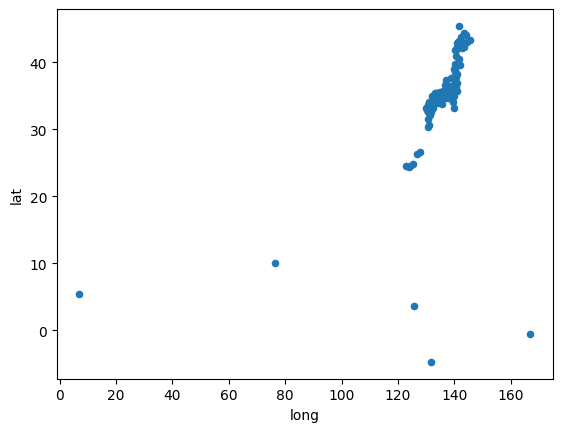

In [150]:
df["lat"] = pd.to_numeric(df["lat"], errors='coerce')
df["long"] = pd.to_numeric(df["long"], errors='coerce')

df.plot(kind="scatter", x="long", y="lat")
# plt.show()

So there's our map of japan, sort of! 

We still have to input some of the missing locations manually, but there are only three of them. I'm going to look those up and do them manually:

In [502]:
# df.info()
null_entries = df[df['lat'].isna()]
null_entries

,Site Name,Currently Being Observed,lat,long,1953,1954,1955,1956,1957,1958,...,2016,2017,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes
73,Shio Misaki,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1958-03-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN
81,Mikihara,False,NaN,NaN,1953-03-28,1954-03-25,1955-03-26,1956-04-06,1957-04-05,1958-03-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN
101,Minami Daito Island,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-02-09,2017-01-27,2018-01-07,2019-01-25,2020-02-06,NaN,2022-01-28,2023-02-07,1 20,Taiwan cherry (Prunus campanulata)


In [ ]:
#minami daito

df.loc[101, 'lat'] =25.8288
df.loc[101, 'long'] =131.2321

# shio misaki is (i am assuming) shio no misaki
df.loc[73, 'lat'] =33.3883
df.loc[73, 'long'] =135.5667

#mikihara
# I couldn't find anywhere called mikihara in japan, and there are too many
# similar-sounding names (makihara, makinohara, mitakihara, etc) so i will drop this one
df.drop(81, inplace=True)

In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 101
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site Name                  101 non-null    object 
 1   Currently Being Observed   101 non-null    bool   
 2   lat                        101 non-null    float64
 3   long                       101 non-null    float64
 4   1953                       78 non-null     object 
 5   1954                       80 non-null     object 
 6   1955                       81 non-null     object 
 7   1956                       83 non-null     object 
 8   1957                       82 non-null     object 
 9   1958                       82 non-null     object 
 10  1959                       85 non-null     object 
 11  1960                       84 non-null     object 
 12  1961                       85 non-null     object 
 13  1962                       87 non-null     object 
 14 

In [627]:

#takes date string and returns day of year
def get_day_of_year(datestr):
    # print(datestr)
    try:
        return datetime.datetime.strptime(datestr, "%Y-%m-%d").timetuple().tm_yday
    except:
        return None

def fix_column(col):
    days = []
    for date in col:
        days.append(get_day_of_year(date))
    return days
        

In [629]:
normalized_hanami = df.copy()
normalized_hanami.iloc[:,4:75] = df.iloc[:, 4:75].apply(fix_column)

In [516]:
normalized_hanami.head()

,Site Name,Currently Being Observed,lat,long,1953,1954,1955,1956,1957,1958,...,2016,2017,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes
0,Wakkanai,True,45.415811,141.673031,141.0,137.0,137.0,133.0,138.0,143.0,...,134.0,129.0,132.0,127.0,131.0,128.0,126.0,123.0,5 13,Sargent cherry (Prunus sargentii)
1,Rumoi,False,-4.725078,131.731661,128.0,131.0,133.0,129.0,130.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,43.762750,142.357926,131.0,133.0,129.0,128.0,129.0,130.0,...,124.0,123.0,120.0,121.0,124.0,119.0,116.0,115.0,5 4,Sargent cherry (Prunus sargentii)
3,Abashiri,True,44.020603,144.273203,144.0,136.0,138.0,130.0,NaN,NaN,...,129.0,125.0,122.0,125.0,128.0,126.0,117.0,118.0,5 10,Sargent cherry (Prunus sargentii)
4,Sapporo,True,43.061936,141.354292,127.0,124.0,131.0,125.0,129.0,NaN,...,116.0,118.0,116.0,114.0,121.0,112.0,113.0,105.0,5 1,NaN


Now we have the day of the year instead of a date string listed! We just have to make them numeric.

In [519]:
normalized_hanami.iloc[:, 4:75] = normalized_hanami.iloc[:, 4:75].apply(pd.to_numeric, errors='coerce')

In [521]:
for col in normalized_hanami.iloc[:, 4:75]:
    # print(col)
    normalized_hanami[col] = pd.to_numeric(normalized_hanami[col], errors='coerce')

So now, we have to make our own average column, to find the recorded average for each site

In [524]:
normalized_hanami.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 101
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site Name                  101 non-null    object 
 1   Currently Being Observed   101 non-null    bool   
 2   lat                        101 non-null    float64
 3   long                       101 non-null    float64
 4   1953                       78 non-null     float64
 5   1954                       80 non-null     float64
 6   1955                       81 non-null     float64
 7   1956                       83 non-null     float64
 8   1957                       82 non-null     float64
 9   1958                       82 non-null     float64
 10  1959                       85 non-null     float64
 11  1960                       84 non-null     float64
 12  1961                       85 non-null     float64
 13  1962                       87 non-null     float64
 14 

In [526]:
normalized_hanami['average'] = normalized_hanami.iloc[: , 4:75].mean(axis=1)
normalized_hanami['average']

0      134.437500
1      130.830189
2      126.422535
3      131.121212
4      123.057143
          ...    
97      37.971429
98      30.360000
99     156.193548
100     28.619048
101     20.352941
Name: average, Length: 101, dtype: float64

### Time to create a training/test set

We want to make sure that both our test set and our training set have a decent spread of target (in this case, our target is the day of first sakura bloom). So we should try and break it up based on the average

<Axes: xlabel='first_bloom_cat'>

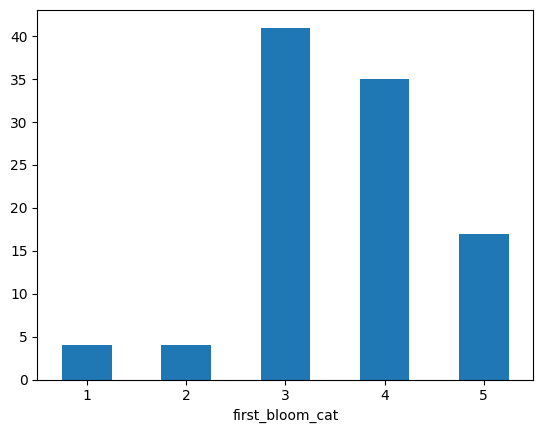

In [530]:
normalized_hanami['first_bloom_cat'] = pd.cut(
    normalized_hanami['average'],
    bins=[ 0., 30, 60, 90 ,120, np.inf],
    labels=[1,2,3,4,5]
)

normalized_hanami['first_bloom_cat'].value_counts().sort_index().plot.bar(rot=0)


Now that we've broken this into rough months, we can do a training and test split:

In [533]:
train_set, test_set = train_test_split(
    normalized_hanami, test_size=0.2, random_state=17)

len(train_set)

80

I wanted to do a stratified split but I was getting an error; i think it has to do with how small the data set is, but i'm not sure.

### Let's do some more visualizations!


In [537]:
hanami = train_set.copy()

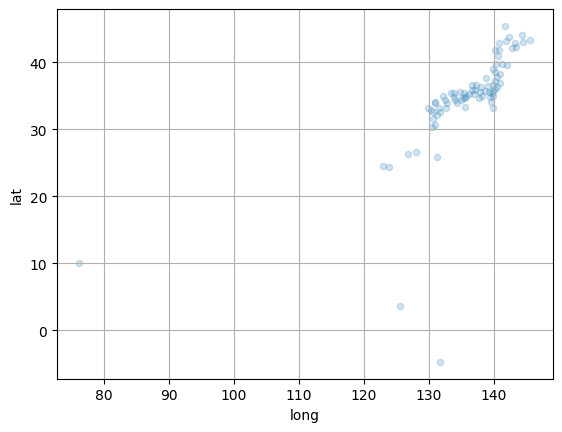

In [539]:
hanami.plot(kind="scatter", x="long", y="lat", grid=True, alpha=.2)
plt.show()

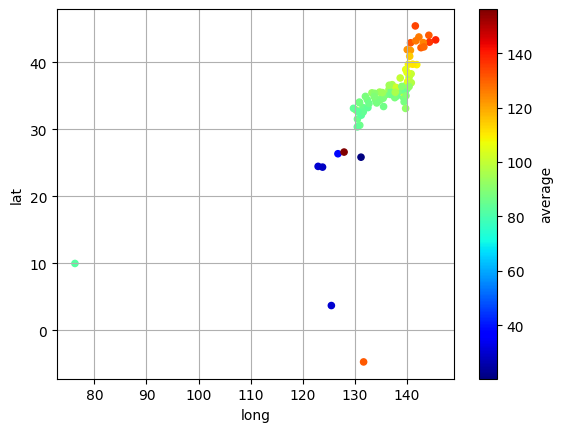

In [541]:
hanami.plot(kind="scatter", x="long", y="lat", grid=True,
           c='average', cmap="jet")
plt.show()

#### AMAZING. 

Now we have a visualization of when geographically the hanami bloom. it is as expected: the farther north, the later the bloom. Let's see about some correlations!

In [544]:
corr_matrix = hanami.drop(columns = ["Site Name", "30 Year Average 1981-2010", "Notes"]).corr()

In [546]:
corr_matrix

,Currently Being Observed,lat,long,1953,1954,1955,1956,1957,1958,1959,...,2016,2017,2018,2019,2020,2021,2022,2023,average,first_bloom_cat
Currently Being Observed,1.000000,0.076611,-0.030371,-0.083988,-0.120457,0.007714,-0.110308,-0.002397,-0.184791,0.025670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.062959,-0.079207
lat,0.076611,1.000000,0.677890,0.291814,0.246210,0.332471,0.308478,0.326102,0.285971,0.734105,...,0.792091,0.795947,0.797548,0.814505,0.790984,0.815323,0.827829,0.814127,0.487392,0.455155
long,-0.030371,0.677890,1.000000,0.612025,0.340972,0.406721,0.400666,0.373474,0.386554,0.427737,...,0.365912,0.344086,0.395194,0.383824,0.332905,0.398176,0.400144,0.354858,0.449021,0.454871
1953,-0.083988,0.291814,0.612025,1.000000,0.968838,0.977024,0.958642,0.966427,0.976464,0.957871,...,0.955730,0.959075,0.972128,0.970145,0.948276,0.967600,0.964506,0.950648,0.977327,0.881674
1954,-0.120457,0.246210,0.340972,0.968838,1.000000,0.964438,0.951508,0.973626,0.980817,0.978974,...,0.979463,0.974513,0.977210,0.975757,0.974374,0.982704,0.961588,0.974844,0.977838,0.874508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,NaN,0.815323,0.398176,0.967600,0.982704,0.976958,0.942489,0.966380,0.969815,0.972762,...,0.991111,0.981388,0.986038,0.988950,0.985289,1.000000,0.980967,0.986371,0.986205,0.850765
2022,NaN,0.827829,0.400144,0.964506,0.961588,0.966841,0.983402,0.974554,0.972367,0.970719,...,0.975755,0.982829,0.987284,0.991145,0.965924,0.980967,1.000000,0.973564,0.983983,0.891938
2023,NaN,0.814127,0.354858,0.950648,0.974844,0.958440,0.918928,0.930250,0.942895,0.956495,...,0.990387,0.980803,0.965955,0.980243,0.993095,0.986371,0.973564,1.000000,0.957265,0.837655
average,-0.062959,0.487392,0.449021,0.977327,0.977838,0.983796,0.977979,0.974737,0.986050,0.976142,...,0.975007,0.972308,0.994189,0.984430,0.958242,0.986205,0.983983,0.957265,1.000000,0.928018


It's really hard to tell here, due to the way the data is structured.

Really, a better way to structure this data would be for each row to represent one record, and the columns should be "year" "date of first bloom", "site name", "lat" and "long". This would give me way more rows, and no NaN. 

SO, to do this, we want to "melt" the dataframe. first, we'll get rid of some of the columns we don't need (like averages, etc). Then we'll call the .melt() method to split the row into multiple entries:

After using pd.melt(), each original row (representing one location) will be split into multiple rows — one for each year.

For example, if you currently have a single row for a location with columns for years (e.g., 2001, 2002, 2003), this row will be "melted" into multiple rows: one for each year with corresponding day_of_year values. The final structure will look like this:

|location	|year|	day_of_year|
---|---|---|
|Location1|2001|	95|
|Location1	|2002	|102|
|Location1|	2003	|87|
|Location2|	2001	|105|
|...|	...|	...|
What was one row for each location will now be many rows — one per year for each location.

In [ ]:
simplified = hanami.drop(['30 Year Average 1981-2010', 'Currently Being Observed',  "first_bloom_cat", "average"],axis=1)

melted_data = pd.melt(simplified, id_vars=[ 'lat', 'long', 'Site Name', "Notes"], var_name='year',value_name='day_of_year')

now we have to get rid of any entries that don't have a record for the day of the year, 
and make sure that the year column is numeric

In [594]:
cleaned = melted_data.dropna(subset=["day_of_year"])

cleaned["year"] = pd.to_numeric(cleaned["year"], errors='coerce')

cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4751 entries, 0 to 5678
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          4751 non-null   float64
 1   long         4751 non-null   float64
 2   Site Name    4751 non-null   object 
 3   Notes        858 non-null    object 
 4   year         4751 non-null   int64  
 5   day_of_year  4751 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 259.8+ KB


/var/folders/0c/77zvfgcx7_x9dcfzd5cdgqlw0000gn/T/ipykernel_57954/3754745707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned["year"] = pd.to_numeric(cleaned["year"], errors='coerce')


perfect, that's actually exactly what we wanted. so now, we have the first one, hanami, which we can use to track the location averages, and the full data set of all records:

### HANAMI GROUPED BY LOCATION

In [596]:
hanami

,Site Name,Currently Being Observed,lat,long,1953,1954,1955,1956,1957,1958,...,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes,average,first_bloom_cat
55,Oshima,False,34.737515,139.400251,95.0,85.0,NaN,80.0,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,87.865385,3
89,Kagoshima,True,31.521587,130.547408,88.0,90.0,88.0,87.0,91.0,85.0,...,76.0,84.0,92.0,76.0,79.0,83.0,3 26,NaN,85.408451,3
71,Sumoto,False,34.338991,134.859985,89.0,86.0,89.0,89.0,96.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,89.200000,3
73,Shio Misaki,False,33.388300,135.566700,NaN,NaN,NaN,NaN,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,86.470588,3
84,Oita,True,33.239386,131.609652,85.0,86.0,84.0,91.0,96.0,86.0,...,82.0,83.0,85.0,77.0,82.0,83.0,3 24,NaN,85.563380,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,Iida,False,35.514710,137.821952,97.0,93.0,94.0,97.0,102.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,96.092593,4
57,Hachijojima,False,33.102494,139.807694,86.0,93.0,80.0,88.0,92.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,91.771930,4
22,Sakata,False,38.914723,139.836410,105.0,101.0,100.0,108.0,107.0,103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,105.263158,4
6,Obihiro,True,42.923809,143.196632,135.0,127.0,130.0,126.0,129.0,133.0,...,117.0,118.0,123.0,114.0,112.0,110.0,5 2,Sargent cherry (Prunus sargentii),125.140845,5


### HANAMI INDIVIDUAL RECORDS

In [599]:
cleaned

,lat,long,Site Name,Notes,year,day_of_year
0,34.737515,139.400251,Oshima,NaN,1953,95.0
1,31.521587,130.547408,Kagoshima,NaN,1953,88.0
2,34.338991,134.859985,Sumoto,NaN,1953,89.0
4,33.239386,131.609652,Oita,NaN,1953,85.0
5,35.254276,136.215376,Hikone,NaN,1953,95.0
...,...,...,...,...,...,...
5669,35.185105,136.899844,Nagoya,NaN,2023,76.0
5671,36.389342,139.063283,Maebashi,NaN,2023,77.0
5672,34.858133,133.775926,Okayama,NaN,2023,81.0
5673,36.561627,136.656882,Kanazawa,NaN,2023,82.0


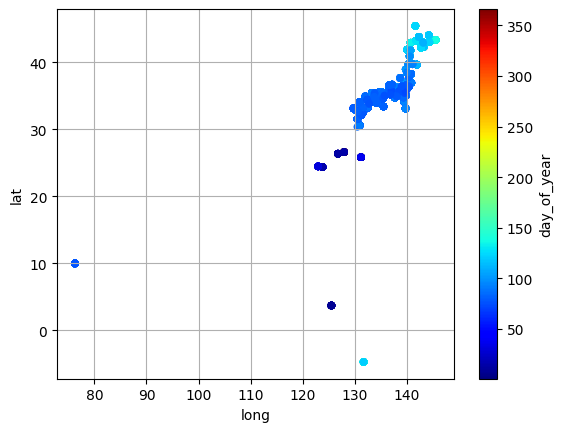

In [601]:
# cleaned.plot(kind="scatter", x="long", y="lat", grid=True, alpha= .2)
cleaned.plot(kind="scatter", x="long", y="lat", grid=True,
           c='day_of_year', cmap="jet", )
plt.show()

<Axes: xlabel='year', ylabel='day_of_year'>

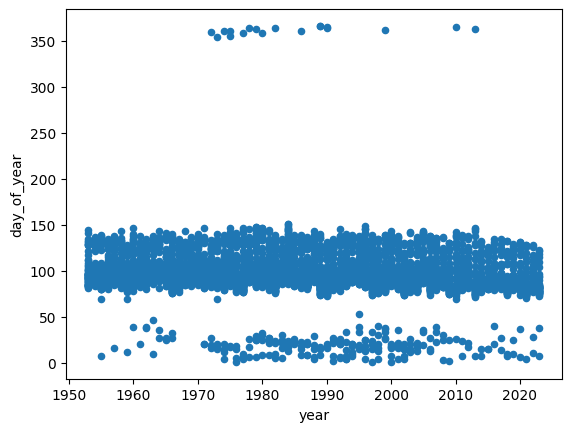

In [603]:
cleaned.plot(kind="scatter",x="year", y="day_of_year")

It looks like in a few cases, the first bloom was in december (likely in okinawa). this is making it look like there was a very late bloom, when it was actually a very early bloom! we should massage this to show that (so, if the first bloom was december 25, it should be day of year = -6 instead of 350)

In [606]:
def normalize_day(day):
    if day > 300:
        day = day-356
    return day

new = cleaned.copy()
new['day_of_year'] =cleaned['day_of_year'].apply(normalize_day)

<Axes: xlabel='year', ylabel='day_of_year'>

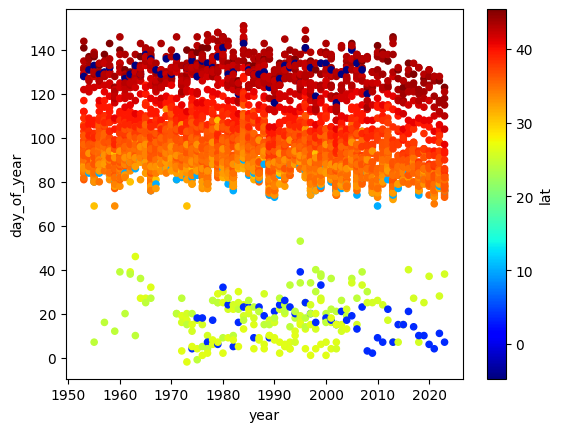

In [608]:
new.plot(kind="scatter",x="year", y="day_of_year", c="lat", cmap="jet")

### PERFECT

Now I've color coded it -- we have all ~4800 records mapped out by year and day, color coded by latitude. very interesting!!!!

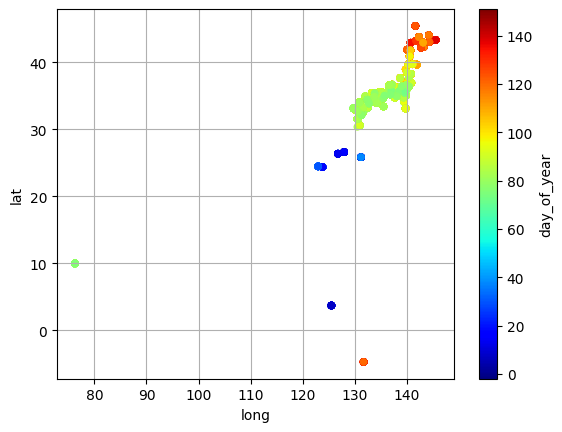

In [611]:
new.plot(kind="scatter", x="long", y="lat", grid=True,
           c='day_of_year', cmap="jet", )
plt.show()

Now let's make a scatter matrix

<class 'pandas.core.frame.DataFrame'>
Index: 4751 entries, 0 to 5678
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          4751 non-null   float64
 1   long         4751 non-null   float64
 2   Site Name    4751 non-null   object 
 3   Notes        858 non-null    object 
 4   year         4751 non-null   int64  
 5   day_of_year  4751 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 259.8+ KB


array([[<Axes: xlabel='day_of_year', ylabel='day_of_year'>,
        <Axes: xlabel='year', ylabel='day_of_year'>],
       [<Axes: xlabel='day_of_year', ylabel='year'>,
        <Axes: xlabel='year', ylabel='year'>]], dtype=object)

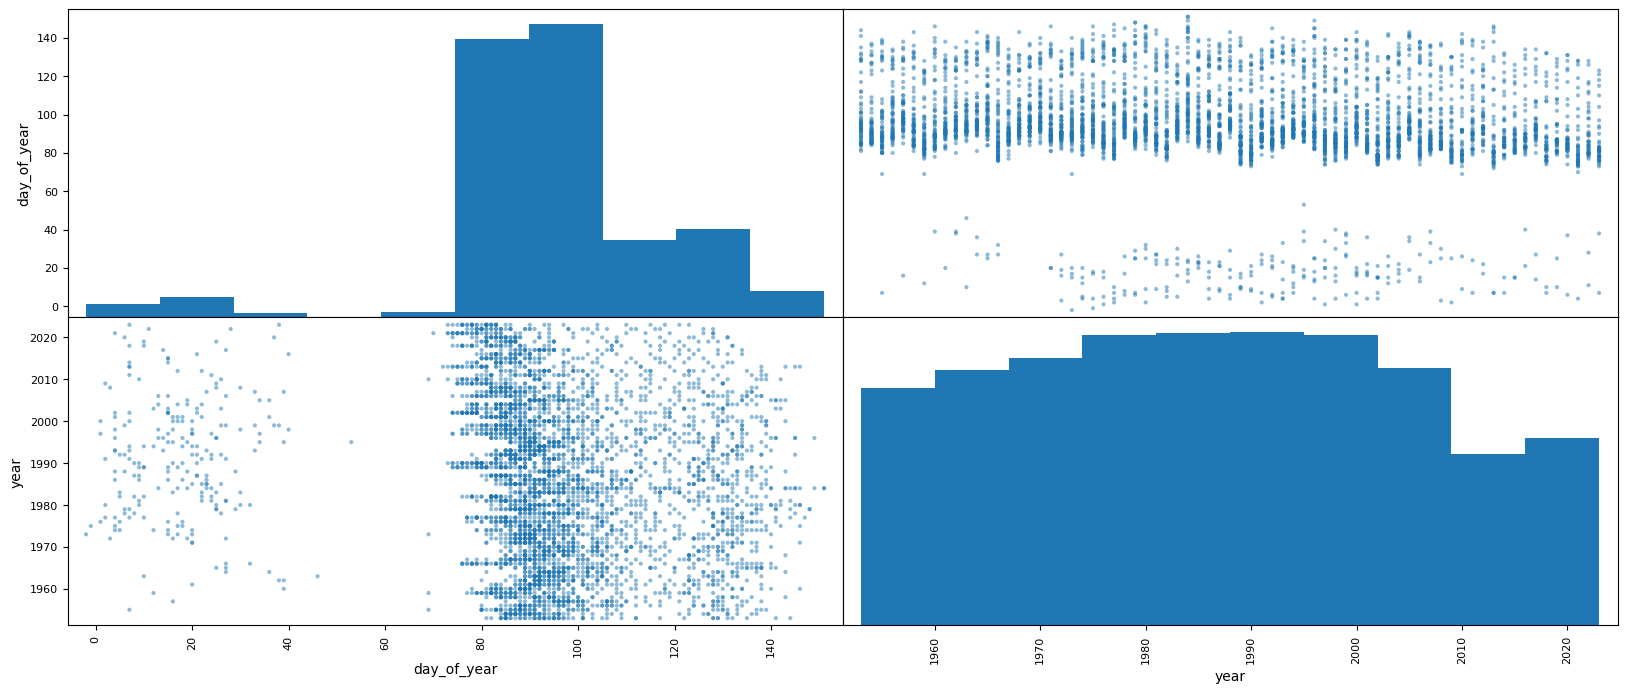

In [620]:
new.info()

attributes = [ "day_of_year", "year", ]

scatter_matrix(new[attributes], figsize=(20,8))

It's pretty hard to see if there's any trend here at all; I feel like it should be getting earlier due to climate change but that's my bias. There's a lot fewer records after around 2005; I wonder if there's more data out there somewhere.

## Feature Scaling

Now it's time to scale these features -- just the numeric ones, of course, so that they all have just about the same impact on the overall graphs. but first, let's separate the features (lat, long, and year) from the target/label (day of year)

In [703]:
sakura = new.drop("day_of_year", axis=1)
sakura_labels = new["day_of_year"].copy()

In [890]:
std_scaler = StandardScaler()

hanami_num_std_scaled = std_scaler.fit_transform(sakura.drop(["Site Name", "Notes"], axis=1))

In [892]:
scaled_hanami_df = pd.DataFrame(hanami_num_std_scaled,columns=sakura.drop(["Site Name", "Notes"], axis=1).columns)

In [894]:
scaled_hanami_df["site"] = new["Site Name"]
scaled_hanami_df["note"] = new["Notes"]

In [896]:
scaled_hanami_df
# new.info()

,lat,long,year,site,note
0,-0.043690,0.405545,-1.740031,Oshima,NaN
1,-0.482228,-0.626414,-1.740031,Kagoshima,NaN
2,-0.098035,-0.123705,-1.740031,Sumoto,NaN
3,-0.247981,-0.502590,-1.740031,NaN,NaN
4,0.026778,0.034290,-1.740031,Oita,NaN
...,...,...,...,...,...
4746,0.017345,0.114077,1.946054,NaN,NaN
4747,0.181560,0.366265,1.946054,Sendai,NaN
4748,-0.027242,-0.250072,1.946054,Osaka,NaN
4749,0.205054,0.085756,1.946054,NaN,NaN


All of a sudden some of the site names and notes are missing from the scaled data... not sure why, will have to come back and investigate later

In [899]:
hanami_df = sakura.copy()


array([[<Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='lat', ylabel='year'>,
        <Axes: xlabel='long', ylabel='year'>],
       [<Axes: xlabel='year', ylabel='lat'>,
        <Axes: xlabel='lat', ylabel='lat'>,
        <Axes: xlabel='long', ylabel='lat'>],
       [<Axes: xlabel='year', ylabel='long'>,
        <Axes: xlabel='lat', ylabel='long'>,
        <Axes: xlabel='long', ylabel='long'>]], dtype=object)

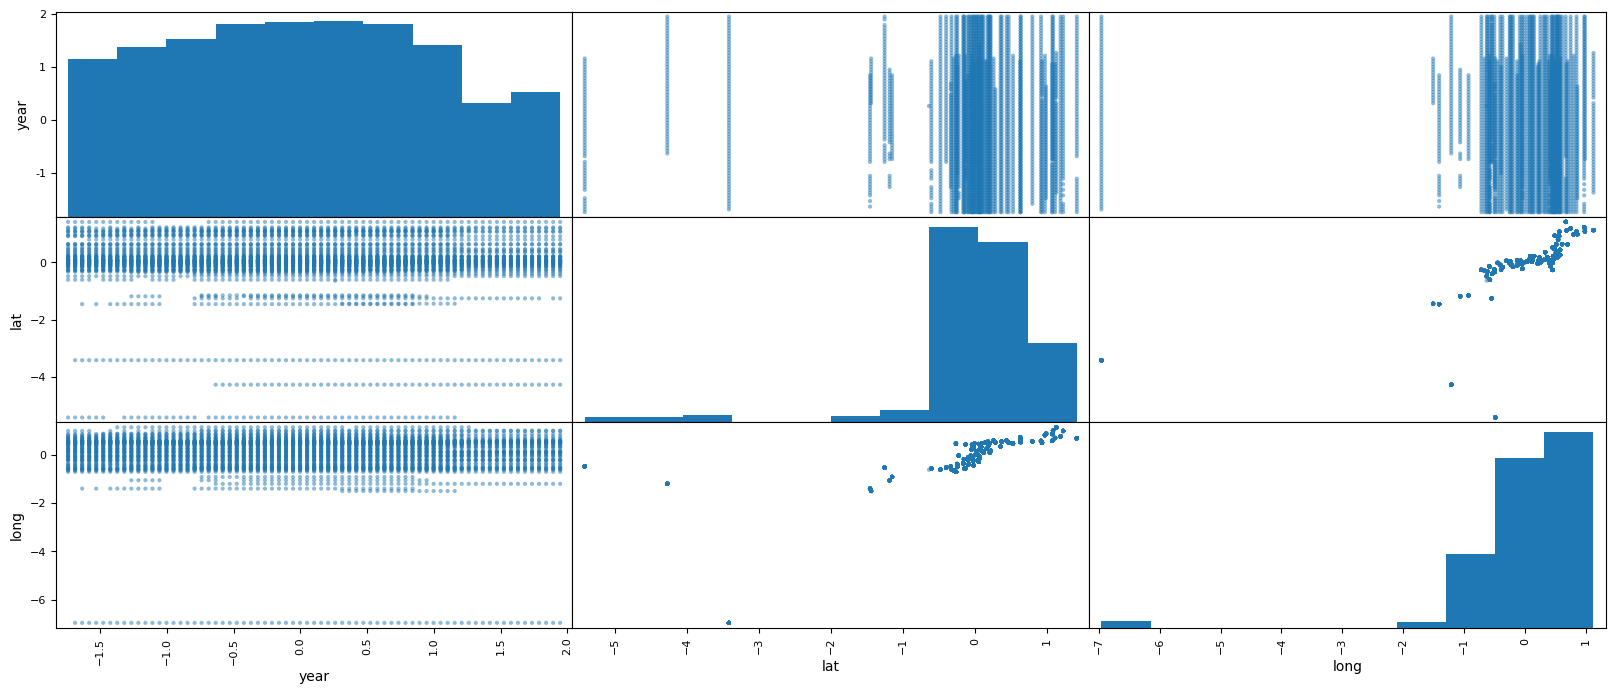

In [901]:
attributes = [ "year", "lat", "long"]

scatter_matrix(scaled_hanami_df[attributes], figsize=(20,8))

## Pipelines

We can combine all the steps we need to do before we train our system; to do that, we create a "pipeline". this is essentially a list of steps and processes your data goes through; you out line it and can then use it on any data set (training, test, new batches, etc!)

# SELECT AND TRAIN THE MODEL

let's try a linear regression first.

In [956]:
# scaled_hanami_df

lin_reg = LinearRegression()
lin_reg.fit(scaled_hanami_df.drop(["site","note"], axis=1), sakura_labels)

LinearRegression()

In [958]:
pred = lin_reg.predict(scaled_hanami_df.drop(["site", "note"],axis=1))

Let's try and visualize it:

ConversionError: Failed to convert value(s) to axis units: array(['Oshima', 'Kagoshima', 'Sumoto', ..., 'Osaka', nan, 'Kofu'],
      dtype=object)

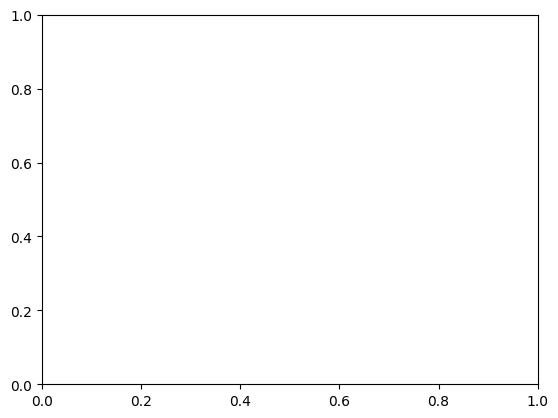

In [973]:
import matplotlib.pyplot as plt
# plt.scatter(scaled_hanami_df.drop(["site","note"], axis=1), sakura_labels, color='blue', label='Data points')

# Plot the regression line
plt.plot(scaled_hanami_df.drop(["site","note"], axis=1), pred, color='red', label='Regression line')

# Add labels and title
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()
len(sakura_labels)


In [910]:
pred[:5]


array([100.39204717,  92.49994007,  98.09944323,  95.3156728 ,
        99.90112335])

In [912]:
sakura_labels.iloc[:5].values

array([95., 88., 89., 85., 95.])

In [914]:
lin_rmse = mean_squared_error(sakura_labels, pred, squared=False)

/Users/kate/src/learn/ml/hanami-ml-project/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [916]:
lin_rmse


np.float64(19.707358378472712)

so what does this mean? It means our linear regression is off by, on average, about 20 days. not so great!! but this is just a linear regression; there's a lot going on here, our data set is quite small truly, and there's a lot more that could be done here.

OK, so we wanna test it out -- find the lat and long for fukuoka, make an array of different years:

In [920]:
test_data = {
    "lat":[33.5902, 33.5902, 33.5902, 33.5902],
    "long":[130.4017, 130.4017, 130.4017, 130.4017],
    "year":[1960, 1990, 2024, 2524]
}

test_df = pd.DataFrame(test_data, columns= ["lat", "long", "year"])

test_df

,lat,long,year
0,33.5902,130.4017,1960
1,33.5902,130.4017,1990
2,33.5902,130.4017,2024
3,33.5902,130.4017,2524


scale it:

In [923]:
scaled_test = std_scaler.transform(test_df)
scaled_df = pd.DataFrame(scaled_test, columns= ["lat", "long", "year"])
scaled_df

,lat,long,year
0,-0.200143,-0.643398,-1.371423
1,-0.200143,-0.643398,0.208328
2,-0.200143,-0.643398,1.998712
3,-0.200143,-0.643398,28.327892


now let's run it through the model:

In [926]:
test_predictions = lin_reg.predict(scaled_df)
test_predictions

array([94.26931614, 89.65198049, 84.41900008,  7.46340584])

#### Ok!!! Now we're onto something. it guessed this year would be the ~84th day (March 25th), when it was actually March 27th -- it's off, but it's close!. The interesting thing is it does seem to have found a trend; it predicted that in 500 years it would be in January.

Let's try the same thing, with a wider range of years in fukuoka, and then one in hokkaido:

In [938]:
test_fuk = {
    "lat":[33.5902, 33.5902, 33.5902, 33.5902],
    "long":[130.4017, 130.4017, 130.4017, 130.4017],
    "year":[1000, 1900, 2024, 3524]
}

fuk_df = pd.DataFrame(test_fuk, columns= ["lat", "long", "year"])

## Wakkanai

test_wak = {
    "lat":[45.4156, 45.4156, 45.4156, 45.4156],
    "long":[141.6734, 141.6734, 141.6734, 141.6734],
    "year":[1960, 1990, 2024, 2524]
}

wak_df = pd.DataFrame(test_wak, columns= ["lat", "long", "year"])

scaled_fuk = std_scaler.transform(fuk_df)
fuk = pd.DataFrame(scaled_fuk, columns= ["lat", "long", "year"])
scaled_wak = std_scaler.transform(wak_df)
wak = pd.DataFrame(scaled_wak, columns= ["lat", "long", "year"])


In [940]:
lin_reg.predict(fuk)

array([ 242.02405707,  103.50398745,   84.41900008, -146.44778263])

In [942]:
lin_reg.predict(wak)

array([115.16452305, 110.54718739, 105.31420699,  28.35861275])

the one for hokkaido is more off: It guessed the first bloom would be the 105th day (April 14) when it was actually the 124(May 4th). That said, it is picking up on that same trend of it being earlier, and the trend of it being later on average in wakkanai than fukuoka. nice!

I think that's enough for today